In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.decomposition import PCA
from sklearn import cluster, manifold
from sklearn.cluster import cluster_optics_dbscan
from sklearn.metrics import silhouette_samples, silhouette_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.svm import LinearSVC
from umap.umap_ import UMAP
from sklearn.pipeline import make_pipeline
import matplotlib.cm as cm
import seaborn as sns
from sklearn.model_selection import GridSearchCV

# Nulls

In [132]:
data = pd.read_csv('../../data/water_potability.csv')
data.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

In [133]:
data

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


In [134]:
data.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [135]:
# fill the null values with the mean
data['ph'].fillna((data['ph'].mean()), inplace=True)
data['Sulfate'].fillna((data['Sulfate'].mean()), inplace=True)
data['Trihalomethanes'].fillna((data['Trihalomethanes'].mean()), inplace=True)



In [136]:
data.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [137]:
Y = data['Potability']
X = data.drop(columns=['Potability'])

# Outliers

In [138]:
data_minmax = MinMaxScaler().fit_transform(X.values)
pca = PCA(0.95, whiten=True)
data_pca = pca.fit_transform(X.values) 

In [139]:
lof = LocalOutlierFactor(n_neighbors=5, metric='euclidean')
lof.fit_predict(data_pca)
scores = lof.negative_outlier_factor_

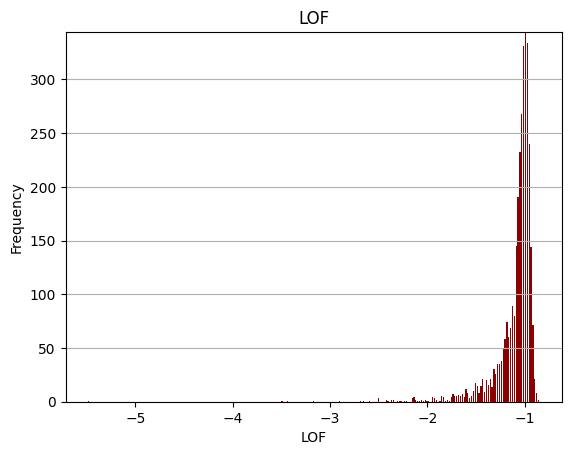

In [140]:
def plot_hist(X: pd.DataFrame, title: str) -> None:
    """ Funcion que genera un grafico de los valores de LOF del dataset """
    x, bins, patches = plt.hist(x=X, bins='auto', rwidth=0.65, color='darkred')
    plt.grid(axis='y')
    plt.xlabel('LOF')
    plt.ylabel('Frequency')
    plt.title(title)
    maxfreq = x.max()
    plt.ylim(ymax=np.ceil(maxfreq))
    
plot_hist(scores, 'LOF')

In [141]:
# Dado el grafico anterior, diremos que un umbral de corte sera aproximadamente -1.85
def lof_threshold(v: float, scores: np.ndarray) -> float:
    ''' Retorna la contaminacion del medio '''
    N = len(scores)
    points = scores[scores < v]
    threshold = len(points)/N
    return threshold 

lof_threshold(-2.5, scores) # APROXimadamente -2.5

0.0027472527472527475

In [142]:
lof = LocalOutlierFactor(n_neighbors=5, metric='euclidean', contamination=0.0027472527472527475)
labels = lof.fit_predict(X.values)
indices = list(np.where(labels==1)[0])
X = X.iloc[indices] # actualizamos la cant. de datos para ambos
Y = Y.iloc[indices]

In [143]:
print(X.shape, Y.shape)

(3267, 9) (3267,)


# Normalizacion


In [144]:
X_scaled = MinMaxScaler().fit_transform(X.values)

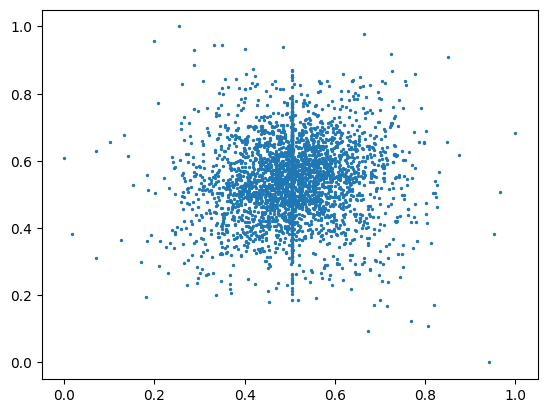

In [145]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], s=2)
plt.show()

# Logistic Regression 
### Solo para probar como era la clasificacion en otros modelos


In [146]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, Y)

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, stratify=y_resampled)

In [148]:
class_counts = pd.Series(y_resampled).value_counts()
print(class_counts)

Potability
0    1992
1    1992
Name: count, dtype: int64


In [149]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

clf = LogisticRegression()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)


0.5083612040133779

In [150]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.52      0.51       598
           1       0.51      0.50      0.50       598

    accuracy                           0.51      1196
   macro avg       0.51      0.51      0.51      1196
weighted avg       0.51      0.51      0.51      1196



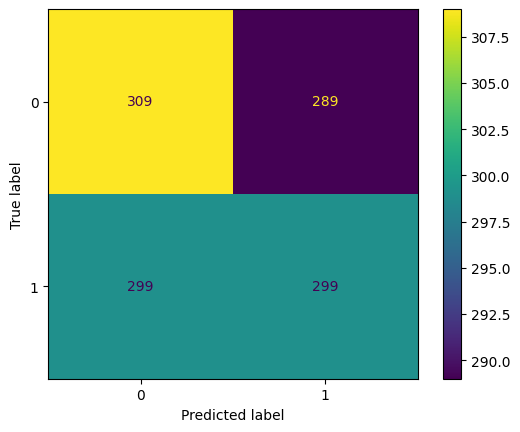

In [151]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

# Observaciones
* Si rellenamos los datos nulos con el promedio de los datos, da un % de prediccion mas alto: 0.61.
* En el caso que eliminemos datos nulos, da un % mas bajo: 0.59
* En general, este modelo presenta gran parte de los datos 
* **La mejor opcion es rellenando los datos segun el promedio**, ya que si eliminamos los nulos, queda totalmente desbalanceado xd

Grid Search

In [152]:
# Define the parameter grid
# Add a separate grid for 'liblinear' and 'saga' which support 'l1'
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'max_iter': [100, 200, 300],
    'tol': [1e-4, 1e-3, 1e-2],
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2'],
    'l1_ratio': [None]
}
# Initialize a LogisticRegression
lr = LogisticRegression()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_parameters)
print("Best Score:", best_score)

# Use the best model
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 504 candidates, totalling 2520 fits
Best Parameters: {'C': 1, 'class_weight': 'balanced', 'l1_ratio': None, 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.01}
Best Score: 0.5261873966397046


In [153]:
# Define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'max_iter': [100, 200, 300],
    'tol': [1e-4, 1e-3, 1e-2],
    'class_weight': [None, 'balanced'],
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'penalty': ['l2', 'none'],
    'l1_ratio': [None]  # Only for elasticnet, but included for compatibility
}

# Initialize a LogisticRegression
lr = LogisticRegression()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_parameters)
print("Best Score:", best_score)

# Use the best model
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 756 candidates, totalling 3780 fits
Best Parameters: {'C': 0.001, 'class_weight': None, 'l1_ratio': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.01}
Best Score: 0.528698287677844
